<img src="../../images/logo.png" style="float:right; max-width: 120px; display: inline" alt="SizingLab" />



# Evaluation models: endurance of the actuator

*Written by Marc Budinger (INSA Toulouse) and Scott Delbecq (ISAE-SUPAERO), Toulouse, France*


## Endurance specifications

In the description of the TVC system given in the [following article](http://esmats.eu/esmatspapers/pastpapers/pdfs/2009/vanthuyne.pdf) an endurance test profile composed of multiple sinusoidal displacements is given. 

*Endurance profile for P80 EMA*

![Endurance profile](./assets/images/EnduranceP80.png)

> Exercice: declare the magnitude displacement, frequency and number of cycles (divided by 100 here) informations in 1D arrays (numpy) for cycles 1 to 6 in a global a Pandas [dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) called 'Profil'.

In [1]:
from IPython.display import Markdown as md  # enable Markdown printing
import numpy as np
import pandas as pd
from math import pi

# Declaration of amplitude, frequency and number of cycles 1 to 6

lever_arm = 1.35  # [m] Lever Arm
stroke = 6 * pi / 180 * lever_arm  # [m] Stroke

profil = pd.DataFrame(
    {
        "A": np.array([0.95, 0.5, 0.3, 0.1, 0.05, 0.05]) * stroke,
        "f": np.array([0.3, 0.6, 1, 2, 5, 3]),
        "Nc": np.array([3700, 4800, 5000, 7000, 8500, 1500]) / 100,
    }
)

profil

,A,f,Nc
0,0.134303,0.3,37.0
1,0.070686,0.6,48.0
2,0.042412,1.0,50.0
3,0.014137,2.0,70.0
4,0.007069,5.0,85.0
5,0.007069,3.0,15.0


with:  
- A [m], magnitude of stroke;
- f [Hz], frequency;
- Nc [-], number of cycles.


## Generation of the test profiles

The target is now to generate from this specification a set of time vectors representing the displacement, speed and acceleration. 

> Exercice: define a [function](https://anh.cs.luc.edu/python/hands-on/3.1/handsonHtml/functions.html) which take as parameters a dataframe *profil* and a time step and return the desired time vectors.
Remark: 'arange', 'concatenate' and 'array' functions of numpy can be usefull. 

In [2]:
def test_profiles(profil, step_size):
    tmin = 0
    time = np.array([])
    position = np.array([])
    speed = np.array([])
    acceleration = np.array([])
    for A, f, Nc in zip(profil.A, profil.f, profil.Nc):
        tmax = Nc / f
        # time vector
        t = np.arange(tmin, tmin + tmax, step_size)
        # Position, speed and Acceleration vectors
        X = A * np.sin(2 * pi * f * t)
        Xp = A * 2 * pi * f * np.cos(2 * pi * f * t)
        Xpp = -A * (2 * pi * f) ** 2 * np.sin(2 * pi * f * t)
        # Concatenation of multiple cycles
        time = np.concatenate((time, t))
        position = np.concatenate((position, X))
        speed = np.concatenate((speed, Xp))
        acceleration = np.concatenate((acceleration, Xpp))
        # new start time for the next cycle
        tmin = tmin + tmax

    d = {
        "t": time,
        "position": position,
        "speed": speed,
        "acceleration": acceleration,
    }

    df = pd.DataFrame(data=d)

    return df


df = test_profiles(profil, 1 / max(profil.f) / 20)

df

,t,position,speed,acceleration
0,0.000000,0.000000,0.253155,-0.000000
1,0.010000,0.002531,0.253110,-0.008994
2,0.020000,0.005062,0.252975,-0.017985
3,0.030000,0.007591,0.252751,-0.026970
4,0.040000,0.010117,0.252436,-0.035945
...,...,...,...,...
31030,310.283333,-0.005719,0.078316,2.031853
31031,310.293333,-0.004839,0.097128,1.719246
31032,310.303333,-0.003788,0.112498,1.345734
31033,310.313333,-0.002602,0.123883,0.924548


The combination of cycles can now be plot :

Text(0, 0.5, 'Acceleration [m/s²]')

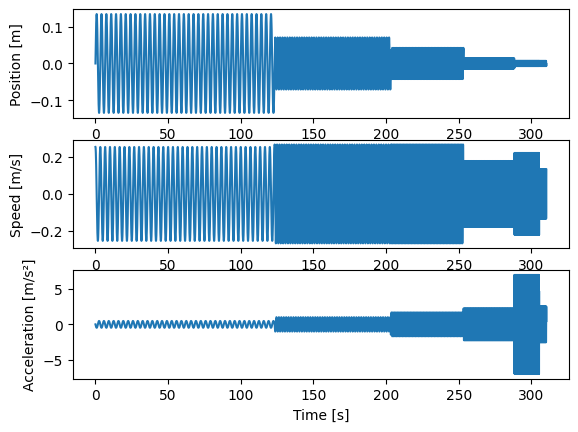

In [3]:
import matplotlib.pyplot as plt

# Position
plt.figure()
plt.subplot(311, xlabel="Time [s]")
plt.plot(df["t"], df["position"])
plt.ylabel("Position [m]")

# Speed
plt.subplot(312, xlabel="Time [s]")
plt.plot(df["t"], df["speed"])
plt.ylabel("Speed [m/s]")

# Acceleration
plt.subplot(313, xlabel="Time [s]")
plt.plot(df["t"], df["acceleration"])
plt.ylabel("Acceleration [m/s²]")

## Force mission profile

> Exercice: Knowing the main characteristics of the nozzle (stiffness of 1.52E+04 Nm/deg, viscous damping of 1.74E+02	Nms/deg, inertia of 1.40E+03 kg.m^2), calculate and plot the mechanical force to be applied by the actuation system. 

Text(0.5, 0, 'Time (s)')

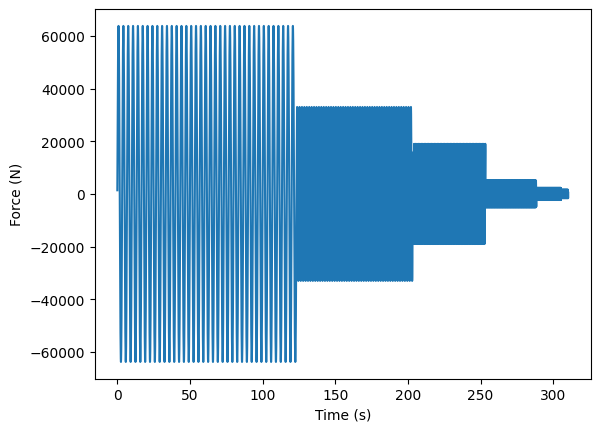

In [4]:
# Definition of nozzle equivalent parameters with engineering units
Jnozzle = 1.40e03  # [kg.m2] Inertia
Knozzle = 1.52e04  # [Nm/deg] Stiffness
Fnozzle = 1.74e02  # [Nms/deg] Viscous damping

# Calculate SI unit values of Knozzle and Fnozzle
# pi value is math.pi

Knozzle = Knozzle / (pi / 180)
Fnozzle = Fnozzle / (pi / 180)

# Angular mission profiles (nozzle)
df["teta"] = df["position"] / lever_arm
df["tetap"] = df["speed"] / lever_arm
df["tetapp"] = df["acceleration"] / lever_arm

# Torque and force calculation
df["Fact"] = (Jnozzle * df["tetapp"] + Fnozzle * df["tetap"] + Knozzle * df["teta"]) / lever_arm

# Plot force mission profile
plt.plot(df["t"], df["Fact"])
plt.ylabel("Force (N)")
plt.xlabel("Time (s)")

## Rolling fatigue

The rolling fatigue for a variable mission profile is evaluated in two stages:
- firstly by calculating the number of revolutions and an equivalent rolling fatigue effort called $F_{RMC}$ (RMC for RootMean Cube)  
$F_{RMC}=(\frac{1}{\int |\dot{x}| {d}t} \int |F|^3 |\dot{x}| {d}t)^{1/3}$
- then by obtaining a fatigue effort $F_d$ equivalent to 1 million rev.   
$F_d^3 . N_{ref} = F_{RMC}^3. N_{cycles}$

We will assume here that the screw/nut system has a pitch of 10 mm/rev. Examples of thrust bearings can be found [here](./PDF/MatchedBearingSKF.pdf).

> Exercice: Calculate $F_{RMC}$ and $F_d$. Compare relative ratio between $C_0$ and $C_d$. Conclusion.  

In [5]:
pitch = 10e-3  # [m/rev] pitch of the roller screw

# Computation of integrals avec np.trapz

# Global distance
distance = np.trapz(abs(df["speed"]), df["t"])

# Cumulative damage
FcubeD = np.trapz(abs(df["Fact"] ** 3 * df["speed"]), df["t"])

# Root Mean Cube
FRMC = (FcubeD / distance) ** (1 / 3)

# Number of rev for the mission profile
Nturn = distance * 100 / pitch

# Dynamic equivalent load
Fd = FRMC * (Nturn / 1e6) ** (1 / 3)

md(
    """
The Root Mean Cube force is *F<sub>RMC</sub>* = {:.0f} kN   
The number of turns = {:.2g}  
The equivalent dynamic load for one million revolutions is *F<sub>d</sub>* = {:.0f} kN
""".format(
        FRMC / 1e3, Nturn, Fd / 1e3
    )
)


The Root Mean Cube force is *F<sub>RMC</sub>* = 31 kN   
The number of turns = 4.9e+05  
The equivalent dynamic load for one million revolutions is *F<sub>d</sub>* = 24 kN


> Exercice for excel users: calculate RMC force and equivalent dynamic force with the mission profile saved in the `FatigueProfil.xlsx` file.

In [6]:
# Profil mission export to excel
df.to_excel("FatigueProfil.xlsx")

## Analytic calculation of equivalent rolling force

The following figures show the evolution of the actuator forces as a function of the position, speed and acceleration. 

> Exercice: Derive from it a simplified approach allowing to calculate the rolling fatigue stress in a fast way directly from the table of specifications of fatigue life cycles. Compare your results with the calculations made directly on the mission profile.

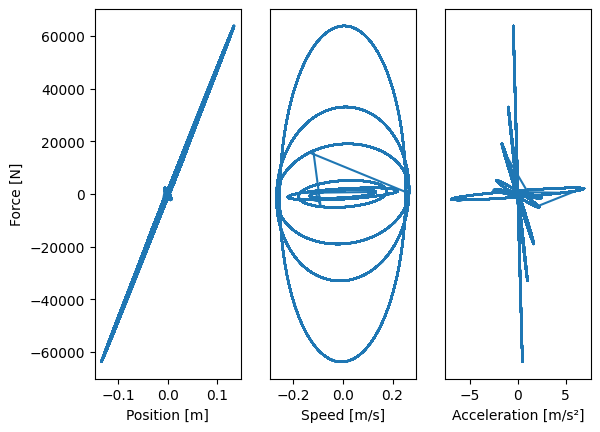

In [7]:
# Plot force mission profile
plt.figure(3)

plt.subplot(131)
plt.plot(df["position"], df["Fact"])
plt.ylabel("Force [N]")
plt.xlabel("Position [m]")

plt.subplot(132)
plt.plot(df["speed"], df["Fact"])
plt.xlabel("Speed [m/s]")
plt.gca().axes.get_yaxis().set_visible(False)

plt.subplot(133)
plt.plot(df["acceleration"], df["Fact"])
plt.xlabel("Acceleration [m/s²]")
plt.gca().axes.get_yaxis().set_visible(False)

The force is mainly proportional to the position:  therefore the effect of the stiffness of the flexible bearing dominates this fatigue cycle. In this case the calculation of the fatigue force can be carried out analytically using the following equations:  
$F_{RMC}=(\frac{1}{\int |\dot{x}| {d}t} \int |F|^3 |\dot{x}| {d}t)^{1/3}$  
where:  
- $F(t)=Kx(t)=F_kcos(\omega_kt)$  with $x(t)=X_kcos(\omega_kt)$ and $F_k=KX_k$    
- $\dot{x}(t)=-X_k\omega_ksin(\omega_kt)$  
with:
- $F_k$ magnitude of sinusoidal forces;
- $A_k$ magnitude of sinusoidal displacements;
- $N_k$ 

Thus:  
$F_{RMC}^3 = \frac{\sum{\frac{F_k^3}{4}A_k N_k}}{\sum{A_k N_k}}$  

We have used following trigonometric formula:  
$cos(\theta)^3sin(\theta) = cos(\theta)^2 sin(\theta)cos(\theta) = \frac{1+cos(2\theta)}{2} \frac{sin(2\theta)}{2}  $  


In [8]:
# Profil
fatigue_profil = pd.DataFrame(
    {
        "A": np.array([0.95, 0.5, 0.3, 0.1, 0.05, 0.05]) * stroke,
        "f": np.array([0.3, 0.6, 1, 2, 5, 3]),
        "Nc": np.array([3700, 4800, 5000, 7000, 8500, 1500]),
    }
)

fatigue_profil["max_force"] = fatigue_profil["A"] * Knozzle / lever_arm**2
fatigue_profil["distance"] = fatigue_profil["A"] * fatigue_profil["Nc"] * 4

fatigue_profil["Feq^3 Distance"] = (
    (fatigue_profil["max_force"]) ** 3 * fatigue_profil["distance"] / 4
)

fatigue_profil

,A,f,Nc,max_force,distance,Feq^3 Distance
0,0.134303,0.3,3700,64177.777778,1987.685672,1.313535e+17
1,0.070686,0.6,4800,33777.777778,1357.168026,1.307576e+16
2,0.042412,1.0,5000,20266.666667,848.230016,1.765227e+15
3,0.014137,2.0,7000,6755.555556,395.840674,3.051010e+13
4,0.007069,5.0,8500,3377.777778,240.331838,2.315499e+12
5,0.007069,3.0,1500,3377.777778,42.411501,4.086174e+11


In [9]:
Frmc = (fatigue_profil["Feq^3 Distance"].sum() / fatigue_profil["distance"].sum()) ** (1 / 3)

md(
    """
The calculated Root Mean Cube force is *F<sub>RMC</sub>* = {:.0f} kN 
which can be compared to previous result.
""".format(
        FRMC / 1e3
    )
)


The calculated Root Mean Cube force is *F<sub>RMC</sub>* = 31 kN 
which can be compared to previous result.
